**Clasificación de estrellas mediante métodos supervisados (Sebastián Oliva A.)**

Este notebook es una demostración de la eficacia de los métodos supervisados "Árboles de desición" y "Regresión Logística", para ello se utilizará un dataset correspondiente a la clasificación de estrellas en relación a distintos parámetros (radio, luminosidad, temperatura, etc.).

**Importar librerías**

Primero se importarán las librerias correspondientes para el análisis:

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
import statsmodels.api as sm

from sklearn import preprocessing

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
plt.style.use('ggplot')

from warnings import filterwarnings
filterwarnings("ignore")

**Análisis del dataset**

Primero se importará el dataset a clasificar:

In [151]:
dataset = pd.read_csv('../input/stars-classifier-clean/6 class csv.csv')
dataset.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


Se puede ver que las estrellas se clasifican segun 6 factores:

* Temperatura en Kelvin (K)
* Luminosidad relativa (L/Lo)
* Radio relativo (R/Ro)
* Magnitud absoluta (Mv)
* Color de su orbita (Star color)
* Clase espectral (Spectral Class)

Y dependiendo de estos factores se clasificarán en 6 tipos de estrellas con su respectivo índice de identificación:

* Enana roja (0)
* Enana café (1)
* Enana blanca (2)
* Secuencia principal (3)
* Supergigantes (4)
* Hipergigantes (5)

Antes de realizar cualquier clasificación se debe verificar que no existan valores perdidos en el dataset, para ello, se usa el siguiente código:

In [152]:
dataset.isnull().sum(axis=0)

Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
Spectral Class            0
dtype: int64

Se hará un análisis del dataset en general. Primero se quiere saber la cantidad de estrellas por colores que existen, para ello se renombrarán la columna "Star color" para un mejor análisis:

In [153]:
dataset = dataset.rename(columns={'Star color':'Color'})
dataset.columns

Index(['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Color', 'Spectral Class'],
      dtype='object')

Luego en la columna "Color" se renombrarán los colores por iniciales:

In [154]:
dataset['Color'] = dataset['Color'].replace(['Red','Blue','Blue White','White','yellow-white','Yellowish White','Yellowish','Whitish','Orange','Pale yellow orange','Orange-Red'], ['R','B','BW','W','YW','YsW','Ys','Ws','O','PYO','OR'])

Finalmente se tiene la cantidad de estrellas por colores:

R      112
B       56
BW      41
W       10
YW       9
YsW      3
Ys       3
Ws       2
O        2
PYO      1
OR       1
Name: Color, dtype: int64


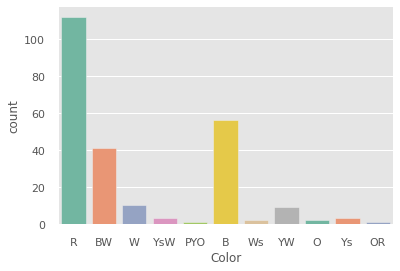

In [155]:
print(dataset['Color'].value_counts())
sns.countplot(x='Color', data=dataset, palette='Set2')
plt.show()

Se puede ver que existe mayor tendencia en estrellas de color Red, la siguen las de color Blue y luego Blue-White. Veamos que tanto influyen los colores según el tipo de estrella:

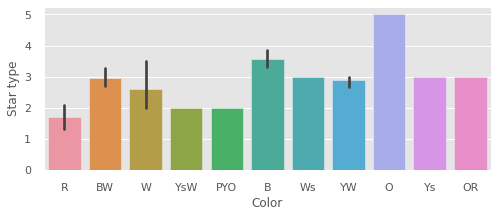

In [156]:
figure = plt.figure(figsize=(8,3))
sns.barplot(x="Color",y="Star type",data=dataset)
plt.show()

Se observa que las de color Blue-White, Whitish, Yellow-White, Yellowish y Orange-Red tienen una tendencia a ser del tipo 3, lo cual corresponde a una estrella de secuencia principal, como nuestro sol. Además, la única estrella de color Orange es considerada una de tipo Hipergigante (5), mientras que las de color Yellowish-White y Pale yellow Orange tienden a ser de tipo Enana blanca (2).

Ahora se analizará la cantidad de estrellas por clase espectral:

M    111
B     46
O     40
A     19
F     17
K      6
G      1
Name: Spectral Class, dtype: int64


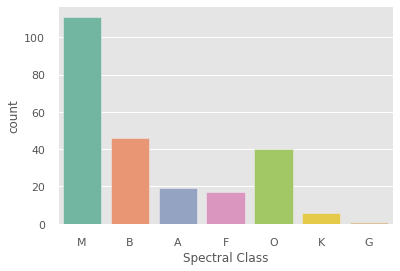

In [157]:
print(dataset['Spectral Class'].value_counts())
sns.countplot(x='Spectral Class', data=dataset, palette='Set2')
plt.show()

Gran cantidad de estrellas son de clase espectral M, mientras que el resto se ve medio opacado a excepción de las tipo B y O.

¿Qué tanto influye la clase espectral en el tipo de estrella?

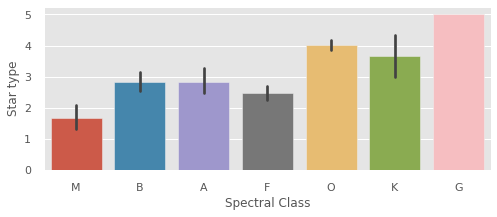

In [158]:
figure = plt.figure(figsize=(8,3))
sns.barplot(x="Spectral Class",y="Star type",data=dataset)
plt.show()

En este caso si son de tipo B o A es casi seguro que serán estrellas de secuencia principal (3), mientras que si son del tipo O y del G es seguro que serán Supergigantes (4) e Hipergigantes (5) respectivamente.

Tanto la temperatura como la luminosidad de la estrella se relacionan mejor con su magnitud absoluta, para un mejor estudio se verán dos gráficos de dispersión con una barra de color que hace alusión al *Diagrama de Hertzsprung-Russell*:

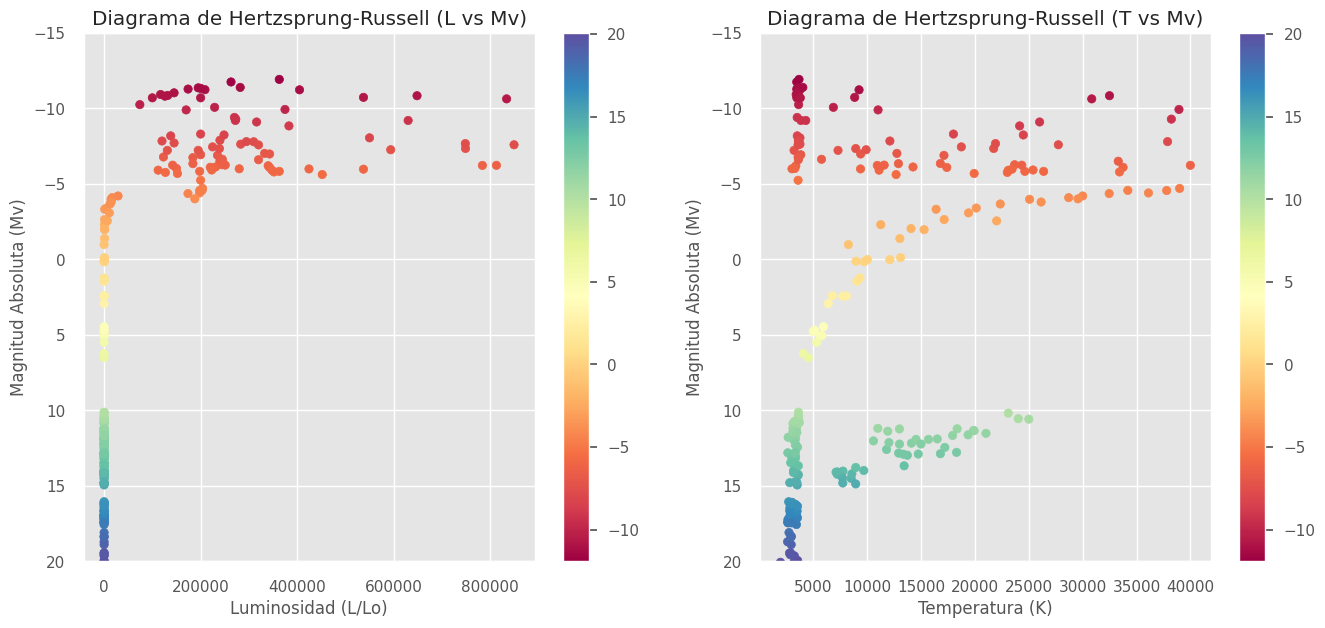

In [159]:
plt.rcParams.update({'figure.figsize':(16,7),'figure.dpi':100})

plt.subplot(1, 2, 1)
plt.ylim([20,-15])
plt.scatter(x=dataset["Luminosity(L/Lo)"], y=dataset["Absolute magnitude(Mv)"], c=dataset["Absolute magnitude(Mv)"], cmap='Spectral')
plt.colorbar()
plt.title('Diagrama de Hertzsprung-Russell (L vs Mv)')
plt.xlabel('Luminosidad (L/Lo)')
plt.ylabel('Magnitud Absoluta (Mv)')

plt.subplot(1, 2, 2)
plt.ylim([20,-15])
plt.scatter(x=dataset["Temperature (K)"], y=dataset["Absolute magnitude(Mv)"], c=dataset["Absolute magnitude(Mv)"], cmap='Spectral')
plt.colorbar()
plt.title('Diagrama de Hertzsprung-Russell (T vs Mv)')
plt.xlabel('Temperatura (K)')
plt.ylabel('Magnitud Absoluta (Mv)')

plt.show()

Si observanos la correlación entre temperatura, luminosidad, radio y magnitud absoluta veremos que tanto se relacionan unas con otras. Tanto por el método "pearson" como por el método "spearman" se obtiene lo siguiente:

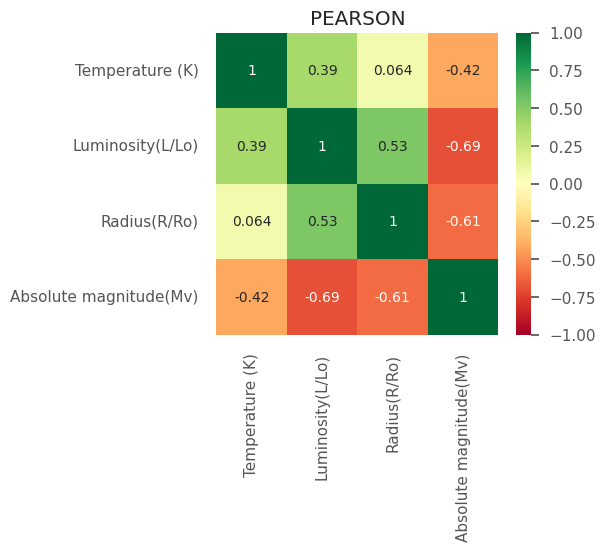

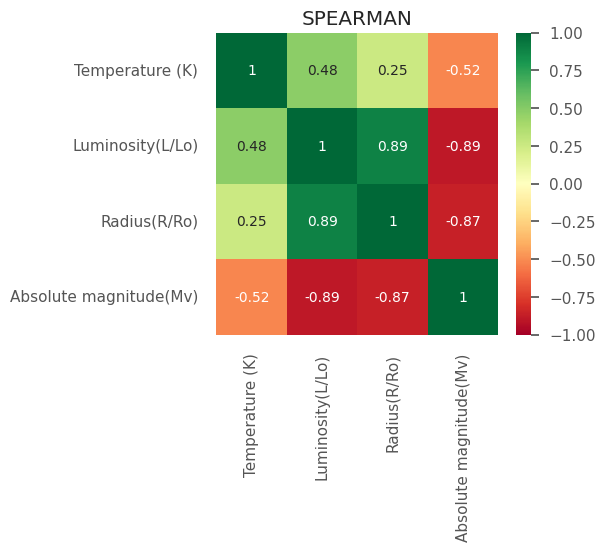

In [160]:
features = ["Temperature (K)","Luminosity(L/Lo)","Radius(R/Ro)","Absolute magnitude(Mv)"]
corrPearson = dataset[features].corr(method="pearson")
corrSpearman = dataset[features].corr(method="spearman")
plt.rcParams.update({'figure.figsize':(10,4),'figure.dpi':100})

plt.subplot(1,2,1)
sns.heatmap(corrPearson,annot=True,cmap='RdYlGn', vmin=-1, vmax=+1)
plt.title("PEARSON")
plt.show()

plt.subplot(1,2,2)
sns.heatmap(corrSpearman,annot=True,cmap='RdYlGn', vmin=-1, vmax=+1)
plt.title("SPEARMAN")
plt.show()

Un coeficiente de correlación mide el grado en que dos variables tienden a cambiar al mismo tiempo. El coeficiente describe tanto la fuerza como la dirección de la relación.

Los coeficientes de correlación de Pearson solo miden relaciones lineales, mientras que los coeficientes de correlación de Spearman solo miden relaciones monótonas, esto se traduce a que en ambas matrices de correlación existan valores distintos.

Las correlaciones negativas quieren decir que las variables son inversamente proporcionales unas con otras, por ejemplo, si el radio aumenta disminuirá la magnitud absoluta. En cambio, las correlaciones positivas quieren decir que las variables son directamente proporcionales unas con otras, el caso de la luminosidad con el radio.

Mediante gráficos 3D se verá la relación entre:

* Temperatura, Luminosidad y Magnitud Absoluta
* Temperatura, Luminosidad y Radio
* Temperatura, Radio y Magnitud Absoluta
* Luminosidad, Radio y Magnitud Absoluta

*Temperatura, Luminosidad y Magnitud Absoluta*

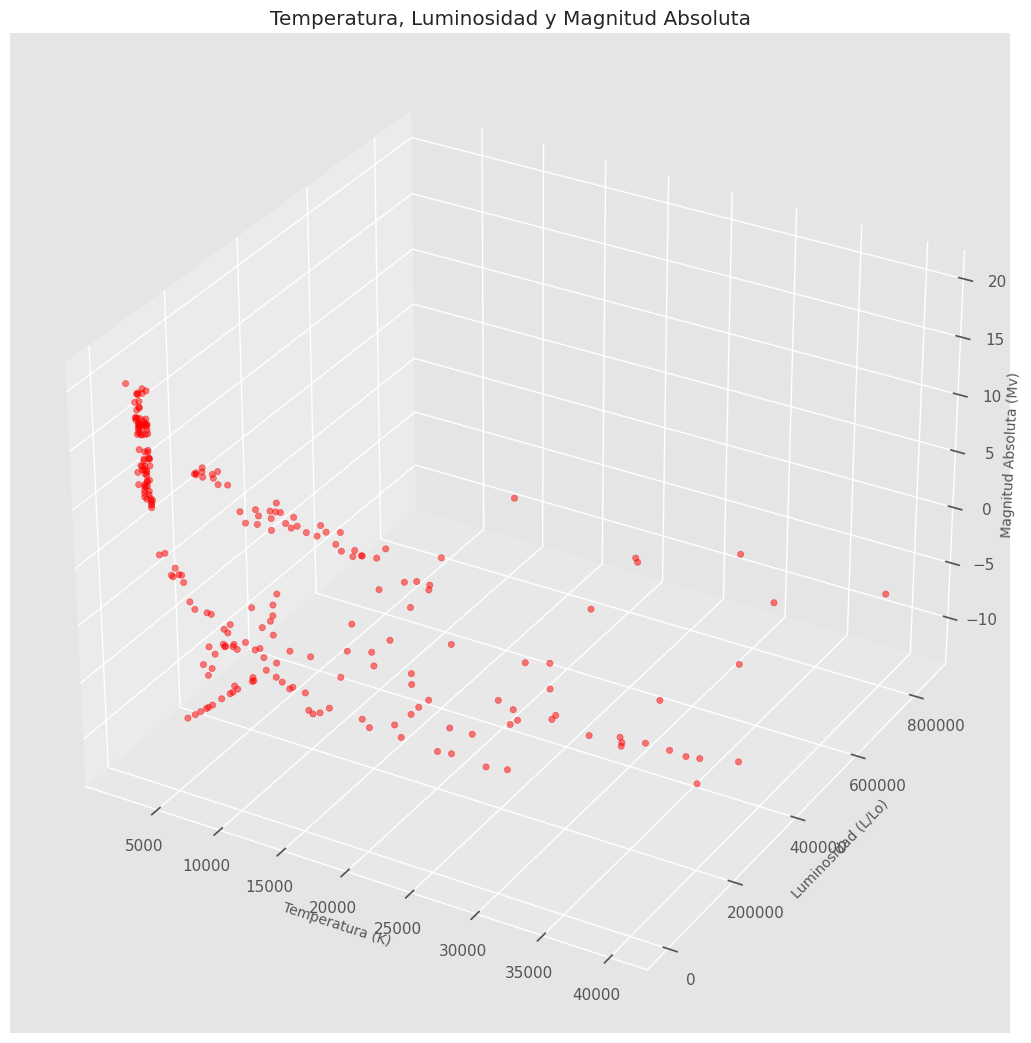

In [161]:
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ax.scatter(dataset["Temperature (K)"], dataset["Luminosity(L/Lo)"], dataset["Absolute magnitude(Mv)"], c="red", s=20, alpha=0.5)
plt.title('Temperatura, Luminosidad y Magnitud Absoluta')
ax.set_xlabel('Temperatura (K)', size=10)
ax.set_ylabel('Luminosidad (L/Lo)', size=10)
ax.set_zlabel('Magnitud Absoluta (Mv)', size=10)
plt.show()

*Temperatura, Luminosidad y Radio*

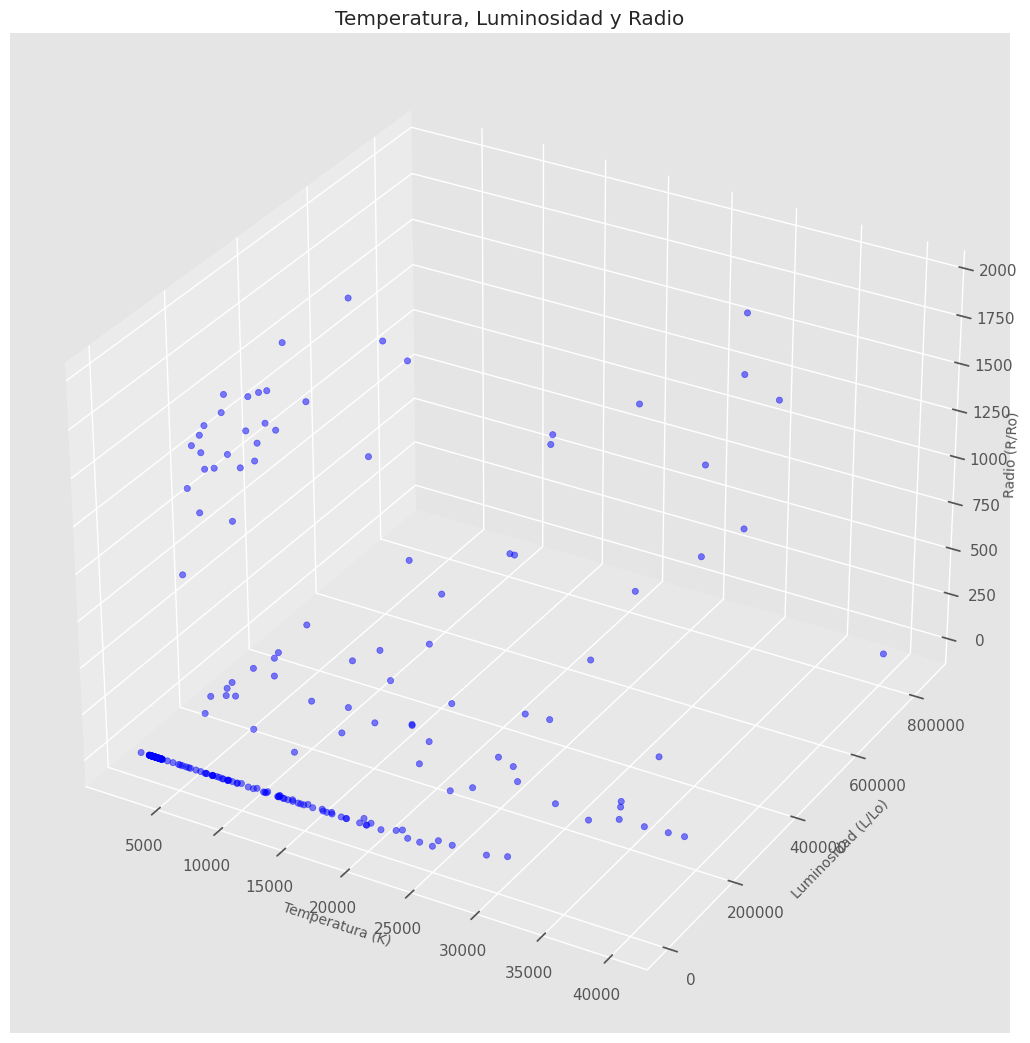

In [162]:
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ax.scatter(dataset["Temperature (K)"], dataset["Luminosity(L/Lo)"], dataset["Radius(R/Ro)"], c="blue", s=20, alpha=0.5)
plt.title('Temperatura, Luminosidad y Radio')
ax.set_xlabel('Temperatura (K)', size=10)
ax.set_ylabel('Luminosidad (L/Lo)', size=10)
ax.set_zlabel('Radio (R/Ro)', size=10)
plt.show()

*Temperatura, Radio y Magnitud Absoluta*

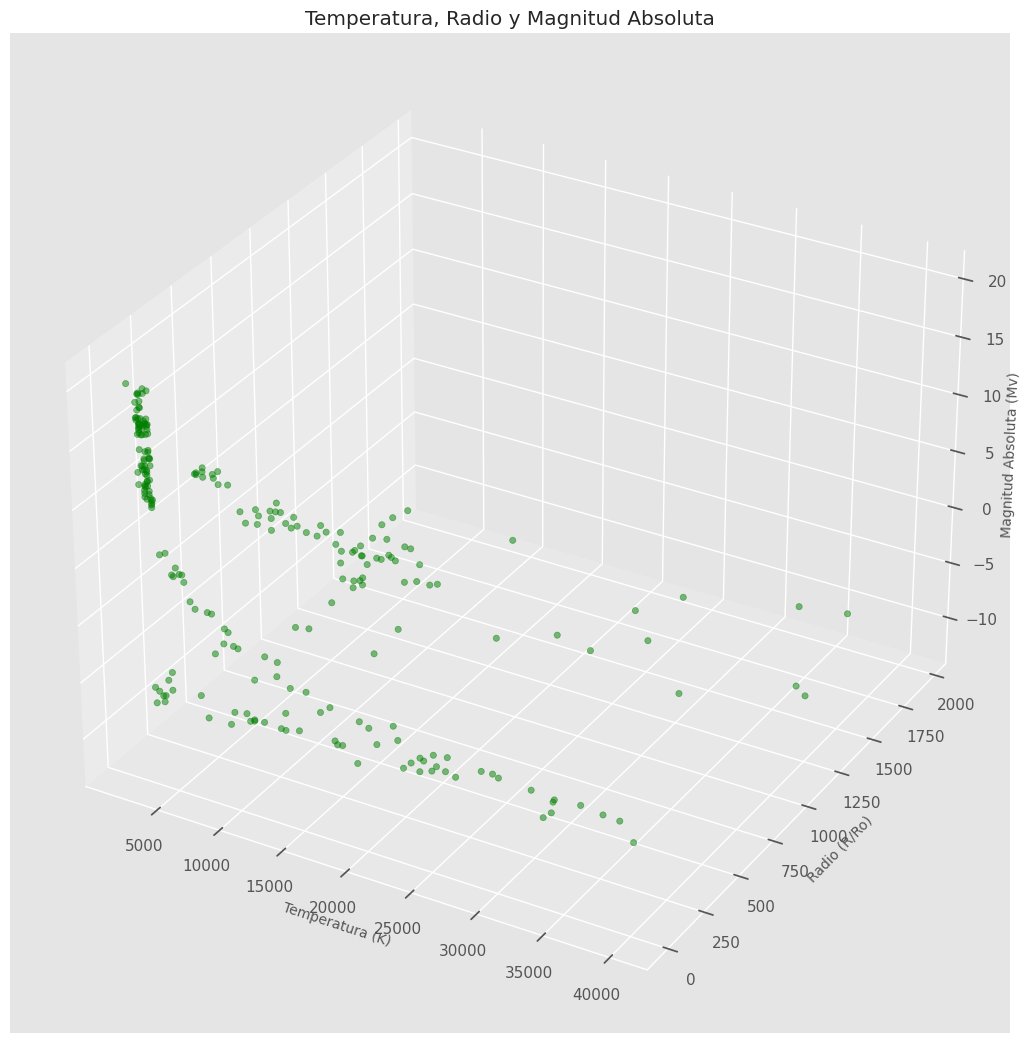

In [163]:
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ax.scatter(dataset["Temperature (K)"], dataset["Radius(R/Ro)"], dataset["Absolute magnitude(Mv)"], c="green", s=20, alpha=0.5)
plt.title('Temperatura, Radio y Magnitud Absoluta')
ax.set_xlabel('Temperatura (K)', size=10)
ax.set_ylabel('Radio (R/Ro)', size=10)
ax.set_zlabel('Magnitud Absoluta (Mv)', size=10)
plt.show()

*Luminosidad, Radio y Magnitud Absoluta*

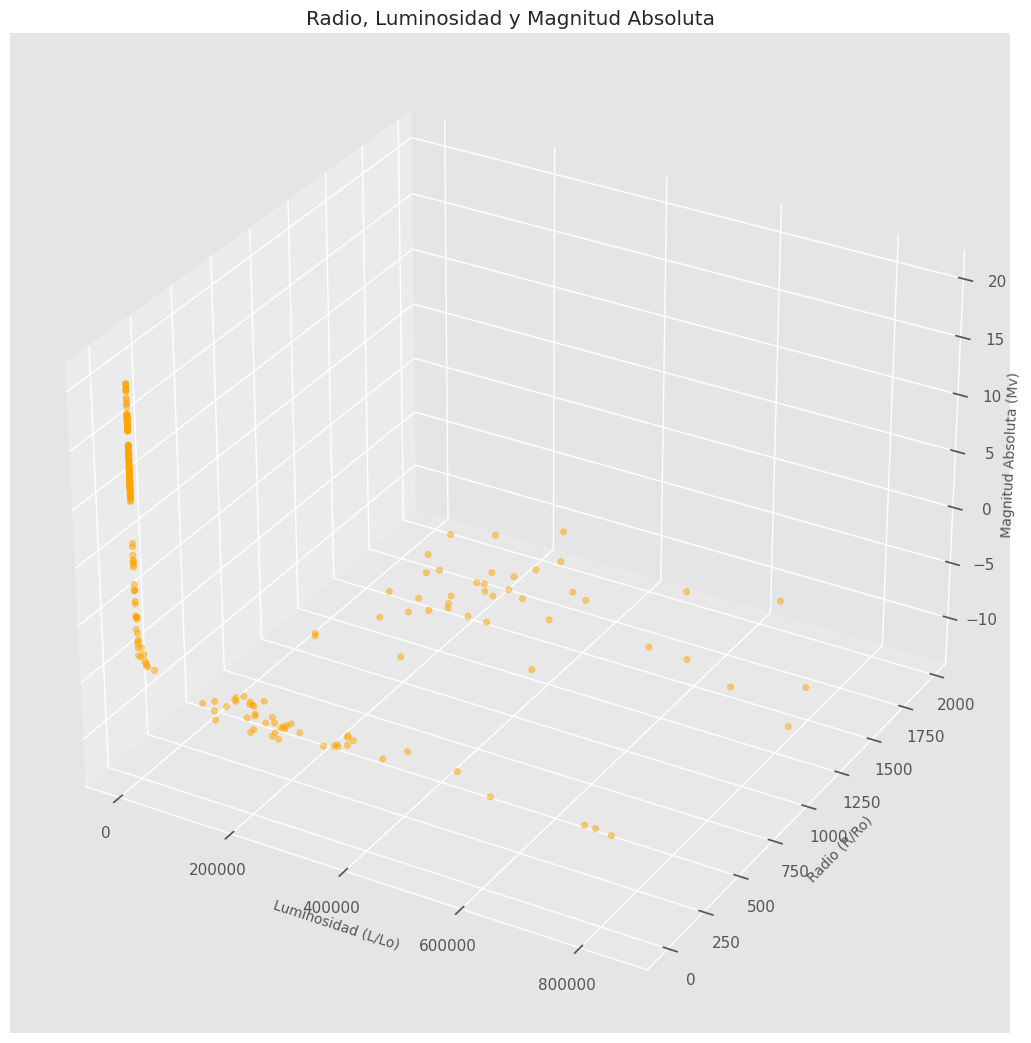

In [164]:
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ax.scatter(dataset["Luminosity(L/Lo)"], dataset["Radius(R/Ro)"], dataset["Absolute magnitude(Mv)"], c="orange", s=20, alpha=0.5)
plt.title('Radio, Luminosidad y Magnitud Absoluta')
ax.set_xlabel('Luminosidad (L/Lo)', size=10)
ax.set_ylabel('Radio (R/Ro)', size=10)
ax.set_zlabel('Magnitud Absoluta (Mv)', size=10)
plt.show()

**Preparando los datos para clasificar**

Como los valores de **Color** y **Spectral_Class** no son números, se deben normalizar a éstos para realizar la clasificación correspondiente, para ello se aplica el siguiente código:

In [165]:
dataset = pd.get_dummies(dataset, columns=['Color', 'Spectral Class'])
dataset.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Color_B,Color_BW,Color_O,Color_OR,Color_PYO,...,Color_YW,Color_Ys,Color_YsW,Spectral Class_A,Spectral Class_B,Spectral Class_F,Spectral Class_G,Spectral Class_K,Spectral Class_M,Spectral Class_O
0,3068,0.002400,0.1700,16.12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,3042,0.000500,0.1542,16.60,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2600,0.000300,0.1020,18.70,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2800,0.000200,0.1600,16.65,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1939,0.000138,0.1030,20.06,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Una vez configurado el dataset se puede aplicar el modelo correspondiente para el clasificador. Se definen las columnas a considerar para la clasificación y se entrena la clase en relación al tipo de estrella:

In [166]:
feat_names = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Color_B', 'Color_BW', 'Color_O', 'Color_OR', 'Color_PYO', 'Color_R', 'Color_W', 'Color_Ws', 'Color_Ys', 'Color_YsW', 'Color_YW', 'Spectral Class_A', 'Spectral Class_B', 'Spectral Class_F', 'Spectral Class_G', 'Spectral Class_K', 'Spectral Class_M', 'Spectral Class_O']
targ_names = ['Enana roja (0)', 'Enana café (1)', 'Enana blanca (2)', 'Secuencia principal (3)', 'Supergigantes (4)', 'Hipergigantes (5)']

train_class = dataset[['Star type']]
train_feature = dataset[feat_names]
train_feature.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Color_B,Color_BW,Color_O,Color_OR,Color_PYO,Color_R,...,Color_Ys,Color_YsW,Color_YW,Spectral Class_A,Spectral Class_B,Spectral Class_F,Spectral Class_G,Spectral Class_K,Spectral Class_M,Spectral Class_O
0,3068,0.002400,0.1700,16.12,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,3042,0.000500,0.1542,16.60,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,2600,0.000300,0.1020,18.70,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,2800,0.000200,0.1600,16.65,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,1939,0.000138,0.1030,20.06,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


**Decision Tree Classifier**

Primero se aplicará el modelo de "Árboles de decisión":

In [167]:
clf = DecisionTreeClassifier(random_state=0)

Se determinará el mejor criterio para el análisis de estos datos, para ello se prueban tanto el criterio "gini" como el criterio "entropy", y a partir de los mejores parámetros obtenidos se decidirá por el criterio adecuado. Para ello se usa el siguiente código:

In [168]:
para_grid = {
    'min_samples_split' : range(10,500,20),
    'max_depth': range(1,20,2),
    'criterion': ("gini", "entropy")
}

clf_tree = DecisionTreeClassifier()
clf_cv = GridSearchCV(clf_tree,
                   para_grid,
                   scoring='accuracy',
                   cv=5,
                   n_jobs=-1)
clf_cv.fit(train_feature,train_class)

best_parameters = clf_cv.best_params_
print(best_parameters)

{'criterion': 'entropy', 'max_depth': 19, 'min_samples_split': 30}


Una vez definido el criterio se realizará una evaluación de su precisión:

In [169]:
clf = clf_cv.best_estimator_
scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro',
           'f1_macro': 'f1_macro'}
scores = cross_validate(clf, train_feature, train_class, cv=10, scoring=scoring)

print ('Accuracy score : %.3f' % scores['test_acc'].mean())
print ('Precision score : %.3f' % scores['test_prec_macro'].mean())
print ('Recall score : %.3f' % scores['test_rec_macro'].mean())
print ('F1 score score : %.3f' % scores['test_f1_macro'].mean())

Accuracy score : 0.996
Precision score : 0.997
Recall score : 0.996
F1 score score : 0.996


Es un método bastante confiable. Se separarán datos entrenados de datos testeados:

In [170]:
X_train, X_test, y_train, y_test = train_test_split(train_feature, train_class, test_size=0.33)
print (str(X_train.shape) +","+ str(y_train.shape))
print (str(X_test.shape) +","+ str(y_test.shape))

(160, 22),(160, 1)
(80, 22),(80, 1)


Luego se obtendrán las métricas de precisión para cada tipo de estrella:

In [171]:
clf2 = clf_cv.best_estimator_
clf2.fit(X_train,y_train)
predictions = clf2.predict(X_test)
print(metrics.classification_report(y_test,predictions, target_names=targ_names, digits=3))

                         precision    recall  f1-score   support

         Enana roja (0)      1.000     1.000     1.000        10
         Enana café (1)      0.818     1.000     0.900         9
       Enana blanca (2)      1.000     1.000     1.000        16
Secuencia principal (3)      1.000     0.882     0.938        17
      Supergigantes (4)      1.000     1.000     1.000        14
      Hipergigantes (5)      1.000     1.000     1.000        14

               accuracy                          0.975        80
              macro avg      0.970     0.980     0.973        80
           weighted avg      0.980     0.975     0.975        80



Para una mejor visualización se utilizará un heatmap:

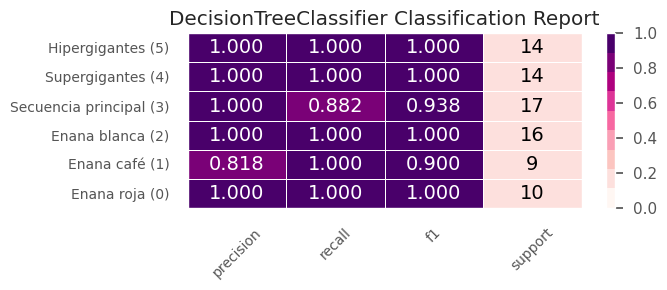

In [172]:
fig, ax = plt.subplots(figsize=(7,3))
visualizer = ClassificationReport(clf2, classes=targ_names, support=True, cmap='RdPu')
visualizer.score(X_test, y_test)
for label in visualizer.ax.texts:
    label.set_size(14)
g = visualizer.poof()

La precisión es suficiente como para determinar alguna predicción. Primero se mostrará el árbol que se ha creado a partir del criterio utilizado:

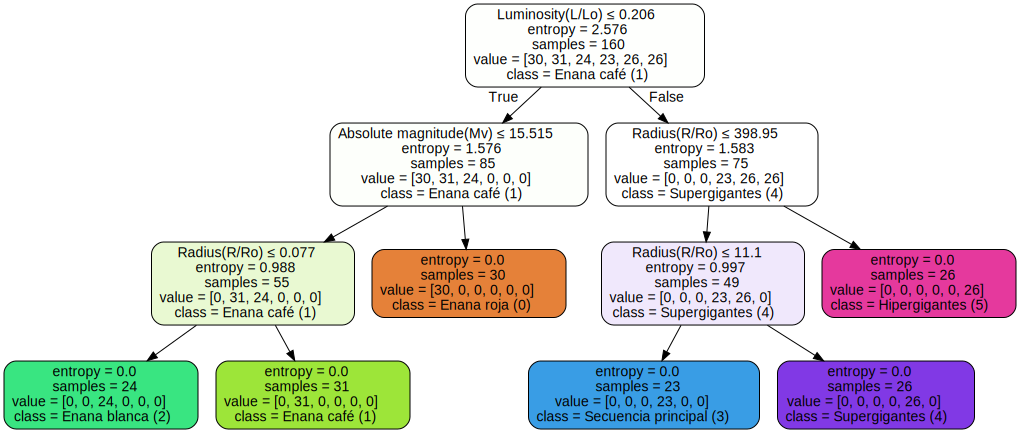

In [173]:
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz

data = export_graphviz(clf,out_file=None,feature_names=feat_names,class_names=targ_names,   
                         filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(data)
graph

Se puede ver que no es un árbol muy complejo, puesto que se dió enfoque a pocas variables para la predicción. Esto queda más claro en el siguiente gráfico:

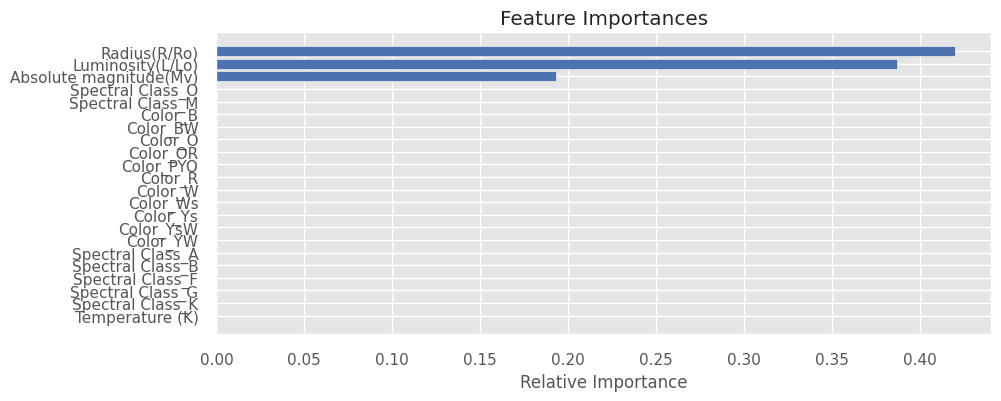

In [174]:
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feat_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Se hará una predicción para el modelo ya entrenado. Se utilizarán los datos de una Enana roja y una Hipergigante, por lo que la predicción debe entregar los valores 0 y 5 respectivamente:

In [175]:
prediccion1 = clf.predict([[3068, 0.002400, 0.1700, 16.12, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])
prediccion2 = clf.predict([[38940, 374830, 1356, -9.93, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
print(prediccion1)
print(prediccion2)

[0]
[5]


Se puede observar que el método de clasificación "Árboles de decisión" actúa de manera precisa.

**Logistic Regression**

Se comienza por definir el modelo como tal:

In [176]:
feat_names = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Color_B', 'Color_BW', 'Color_O', 'Color_OR', 'Color_PYO', 'Color_R', 'Color_W', 'Color_Ws', 'Color_Ys', 'Color_YsW', 'Color_YW', 'Spectral Class_A', 'Spectral Class_B', 'Spectral Class_F', 'Spectral Class_G', 'Spectral Class_K', 'Spectral Class_M', 'Spectral Class_O'] 
X = dataset[feat_names]
y = dataset['Star type']

model = LogisticRegression()

rfe = RFE(model)
rfe = rfe.fit(X, y)

Dado un estimador externo que asigna pesos a las características, la eliminación recursiva de características (RFE) consiste en seleccionar características considerando recursivamente conjuntos de características cada vez más pequeños. Para que aplique de mejor manera se utilizará análogamente RFECV, esto para encontrar el número óptimo o el mejor número de características. A continuación, se aplica una eliminación recursiva de características en regresión logística con ajuste automático del número de características seleccionadas con cross-validation:

In [177]:
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Número óptimo de características: %d" % rfecv.n_features_)
print('Características seleccionadas: %s' % list(X.columns[rfecv.support_]))

Número óptimo de características: 11
Características seleccionadas: ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Color_B', 'Color_R', 'Color_YW', 'Spectral Class_B', 'Spectral Class_F', 'Spectral Class_M', 'Spectral Class_O']


Con las características ya seleccionadas se hace un mapa de calor para determinar su correlación:

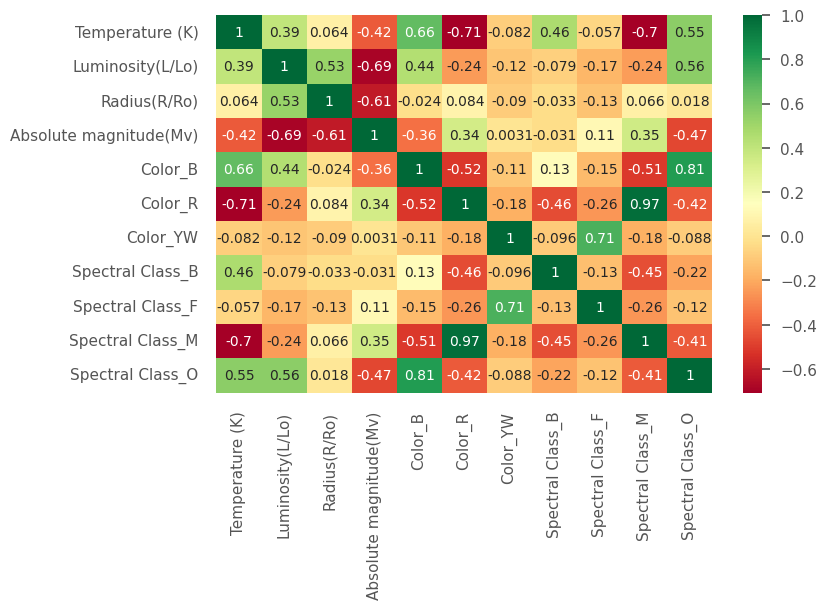

In [178]:
Selected_features = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Color_B', 'Color_R', 'Color_YW', 'Spectral Class_B', 'Spectral Class_F', 'Spectral Class_M', 'Spectral Class_O']
X = dataset[Selected_features]

plt.subplots(figsize=(8, 5))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

Se aplicará el modelo de Regresión Logística, obteniendo su valor de efectividad para este conjunto de datos:

In [179]:
logreg = LogisticRegression()

scores_accuracy = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, X, y, cv=10, scoring='neg_log_loss')
print('K-fold cross-validation results:')
print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())

K-fold cross-validation results:
LogisticRegression average accuracy is 0.596
LogisticRegression average log_loss is 0.767


**Comparación de modelos**

Se realiza una comparación de los dos modelos vistos en el notebook. Para ello se utilizará el siguiente código:



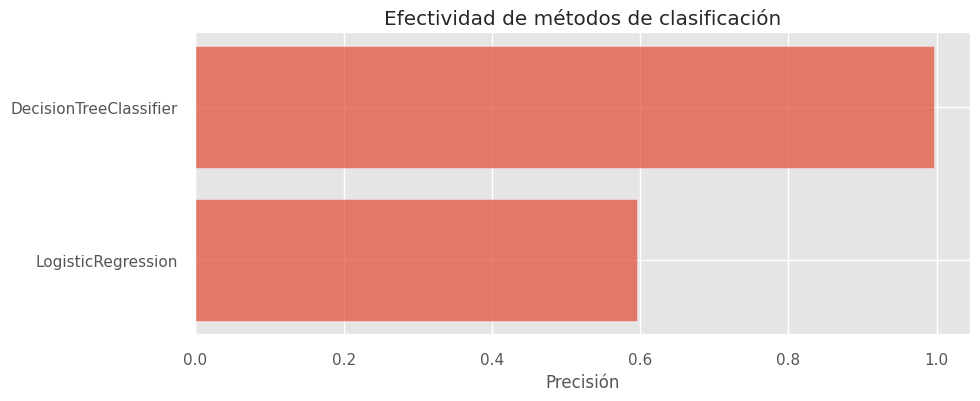

In [180]:
methods = ['DecisionTreeClassifier', 'LogisticRegression']
y_pos = -np.arange(len(methods))
accuracy = [scores['test_acc'].mean(),scores_accuracy.mean()]
plt.barh(y_pos, accuracy, align='center', alpha=0.7)
plt.yticks(y_pos, methods)
plt.xlabel('Precisión')
plt.title('Efectividad de métodos de clasificación')
plt.show()

Es una clara ventaja en este caso para el método "Decision Tree Classifier", por lo que, entre ambos modelos sería más conveniente ocupar el de "Árboles de decisión" para este dataset.